In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Global_Pollution_Analysis.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 200 non-null    object 
 1   Year                                    200 non-null    int64  
 2   Air_Pollution_Index                     200 non-null    float64
 3   Water_Pollution_Index                   200 non-null    float64
 4   Soil_Pollution_Index                    200 non-null    float64
 5   Industrial_Waste (in tons)              200 non-null    float64
 6   Energy_Recovered (in GWh)               200 non-null    float64
 7   CO2_Emissions (in MT)                   200 non-null    float64
 8   Renewable_Energy (%)                    200 non-null    float64
 9   Plastic_Waste_Produced (in tons)        200 non-null    float64
 10  Energy_Consumption_Per_Capita (in MWh)  200 non-null    float6

In [3]:
scaler = MinMaxScaler()
pollution_cols = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
df[pollution_cols] = scaler.fit_transform(df[pollution_cols])

In [4]:
le_country = LabelEncoder()
le_year = LabelEncoder()
df['Country_Encoded'] = le_country.fit_transform(df['Country'])
df['Year_Encoded'] = le_year.fit_transform(df['Year'])

In [5]:
df['Energy_Consumption_Per_Capita_Calc'] = df['Energy_Recovered (in GWh)'] / df['Population (in millions)']

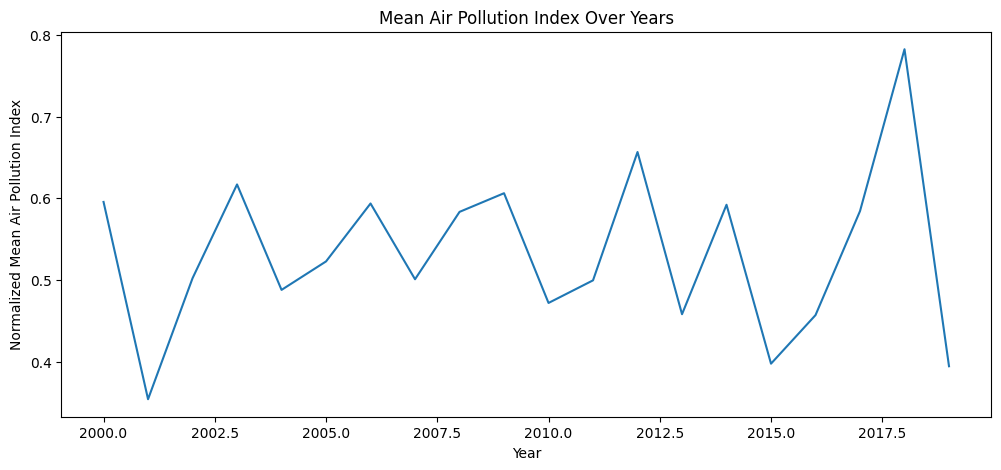

In [6]:
pollution_trend = df.groupby('Year')['Air_Pollution_Index'].mean()
plt.figure(figsize=(12, 5))
plt.plot(pollution_trend.index, pollution_trend.values)
plt.title('Mean Air Pollution Index Over Years')
plt.xlabel('Year')
plt.ylabel('Normalized Mean Air Pollution Index')
plt.show()

In [7]:
def pollution_severity(val):
    if val < 0.33:
        return 'Low'
    elif val < 0.66:
        return 'Medium'
    else:
        return 'High'
df['Air_Severity'] = df['Air_Pollution_Index'].apply(pollution_severity)
df['Water_Severity'] = df['Water_Pollution_Index'].apply(pollution_severity)

In [12]:
from mlxtend.frequent_patterns import apriori, association_rules
basket_df = pd.get_dummies(df[['Country', 'Air_Severity', 'Water_Severity']], prefix=['Country', 'Air', 'Water'])
frequent_itemsets = apriori(basket_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift


In [10]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.9 MB/s eta 0:00:00


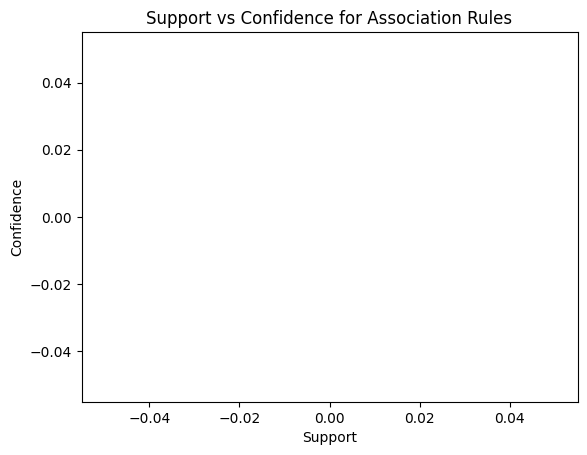

In [13]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence for Association Rules')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
basket_train = pd.get_dummies(train_df[['Country', 'Air_Severity', 'Water_Severity']], prefix=['Country', 'Air', 'Water'])
basket_test = pd.get_dummies(test_df[['Country', 'Air_Severity', 'Water_Severity']], prefix=['Country', 'Air', 'Water'])

In [27]:

frequent_itemsets = apriori(basket_train, min_support=0.01, use_colnames=True)
rules_train = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
print("Rules found:", len(rules_train))


Rules found: 15


In [28]:
def rule_test_support(row, data):
    antecedent_cols = list(row['antecedents'])
    consequent_cols = list(row['consequents'])
    # Only keep the columns that actually exist
    all_needed = [col for col in antecedent_cols + consequent_cols if col in data.columns]
    if not all_needed:
        return 0.0
    # Defensive: If ANY column missing, just skip this rule
    if any(col not in data.columns for col in antecedent_cols + consequent_cols):
        return 0.0
    mask = data[all_needed].all(axis=1)
    return float(mask.mean())  # Make sure to always return a float

# Now use list comprehension instead of .apply() to be bulletproof:
rules_train['test_support'] = [
    rule_test_support(row, basket_test) for _, row in rules_train.iterrows()
]





In [29]:
df.to_csv('Processed_Global_Pollution_Analysis.csv', index=False)
rules.to_csv('Association_Rules.csv', index=False)

In [32]:
# Make sure the columns exist and are of correct type!
def frozenset_to_str(fs):
    return ', '.join([str(item) for item in fs]) if isinstance(fs, (set, frozenset)) else str(fs)

# Now build Rule as a list (not via apply)
rules_as_text = [
    f"{frozenset_to_str(row['antecedents'])} ⇒ {frozenset_to_str(row['consequents'])}"
    for _, row in result_matrix.iterrows()
]
result_matrix = result_matrix.copy()  # no SettingWithCopyWarning
result_matrix['Rule'] = rules_as_text

final_matrix = result_matrix[['Rule', 'support', 'confidence', 'lift', 'test_support']]
print(final_matrix.head())


Empty DataFrame
Columns: [Rule, support, confidence, lift, test_support]
Index: []


In [31]:
print(rules_train.shape)
print(rules_train.head(3))


(15, 15)
         antecedents   consequents  antecedent support  consequent support  \
0  (Country_Croatia)  (Air_Medium)             0.01250                 0.4   
1     (Country_Cuba)  (Air_Medium)             0.01250                 0.4   
2   (Country_Latvia)  (Air_Medium)             0.01875                 0.4   

   support  confidence      lift  representativity  leverage  conviction  \
0   0.0125    1.000000  2.500000               1.0    0.0075         inf   
1   0.0125    1.000000  2.500000               1.0    0.0075         inf   
2   0.0125    0.666667  1.666667               1.0    0.0050         1.8   

   zhangs_metric   jaccard  certainty  kulczynski  test_support  
0       0.607595  0.031250   1.000000    0.515625           0.0  
1       0.607595  0.031250   1.000000    0.515625           0.0  
2       0.407643  0.030769   0.444444    0.348958           0.0  
